In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler 
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
import lightgbm as lgb
from catboost import CatBoostRegressor
from xgboost import XGBRegressor, plot_importance

In [88]:
df_train = pd.read_csv("data/stores_train.csv")
df_test = pd.read_csv("data/stores_test.csv")
df_bus_stops = pd.read_csv("data/busstops_norway_fixed.csv")
df_grunnkrets_age_dist = pd.read_csv("data/grunnkrets_age_distribution.csv")
df_grunnkrets_house_pers = pd.read_csv("data/grunnkrets_households_num_persons.csv")
df_grunnkrets_income_house = pd.read_csv("data/grunnkrets_income_households.csv")
df_grunnkrets_stripped = pd.read_csv("data/grunnkrets_norway_stripped.csv")
df_plaace_hierarchy = pd.read_csv("data/plaace_hierarchy.csv")
df_extra = pd.read_csv("data/stores_extra.csv")

df_new_bs_features_train = pd.read_csv('data/new_bs_features_train.csv')
df_new_bs_features_test = pd.read_csv('data/new_bs_features_test.csv')

In [89]:
df_grunnkrets_stripped = df_grunnkrets_stripped[df_grunnkrets_stripped.year == 2016]
df_grunnkrets_age_dist = df_grunnkrets_age_dist[df_grunnkrets_age_dist.year == 2016]
df_grunnkrets_house_pers = df_grunnkrets_house_pers[df_grunnkrets_house_pers.year == 2016]
df_grunnkrets_income_house = df_grunnkrets_income_house[df_grunnkrets_income_house.year == 2016]

In [90]:
def rmsle(y_true, y_pred):
    """
    Computes the Root Mean Squared Logarithmic Error 
    
    Args:
        y_true (np.array): n-dimensional vector of ground-truth values 
        y_pred (np.array): n-dimensional vecotr of predicted values 
    
    Returns:
        A scalar float with the rmsle value 
    
    Note: You can alternatively use sklearn and just do: 
        `sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5`
    """
    assert (y_true >= 0).all(), 'Received negative y_true values'
    assert (y_pred >= 0).all(), 'Received negative y_pred values'
    assert y_true.shape == y_pred.shape, 'y_true and y_pred have different shapes'
    y_true_log1p = np.log1p(y_true)  # log(1 + y_true)
    y_pred_log1p = np.log1p(y_pred)  # log(1 + y_pred)
    return np.sqrt(np.mean(np.square(y_pred_log1p - y_true_log1p)))

# Fixing Seed

In [91]:
SEED = 42

# Pipeline

In [92]:
def label_uniformier(array_train, array_test):
    """
    Take the unique values from the train and test part to combine it in a single array.
    Useful to fit the label encoder and don't do a mess during the transform (previously fit_transform that was confusing)
    """
    label_encoder = LabelEncoder()
    labels = np.asarray(list(array_train.unique()) + list(set(array_test.unique()) - set(array_train.unique())))
    label_encoder.fit(labels)
    return label_encoder

In [93]:
def create_population_age():
    df_grunnkrets_population = df_grunnkrets_age_dist.loc[:, ['grunnkrets_id']]
    df_grunnkrets_population['total_population'] = df_grunnkrets_age_dist.iloc[:,2:92].sum(axis=1)
#     df_grunnkrets_population['youngs'] = df_grunnkrets_age_dist.iloc[:,2:20].sum(axis=1)
#     df_grunnkrets_population['adults'] = df_grunnkrets_age_dist.iloc[:,21:64].sum(axis=1)
#     df_grunnkrets_population['seniors'] = df_grunnkrets_age_dist.iloc[:,65:92].sum(axis=1)
    return df_grunnkrets_population

In [94]:
def create_population_repartition():
    return df_grunnkrets_house_pers[['grunnkrets_id', 'couple_children_0_to_5_years', 'couple_children_6_to_17_years', 'couple_children_18_or_above', 'couple_without_children', 'single_parent_children_0_to_5_years', 'single_parent_children_6_to_17_years', 'single_parent_children_18_or_above', 'singles']]

In [95]:
def create_income_repartition():
    return df_grunnkrets_income_house[['grunnkrets_id', 'all_households']]

In [96]:
def create_grunnkret_geodata():
    return df_grunnkrets_stripped[['grunnkrets_id', 'area_km2', 'municipality_name']]

In [97]:
def create_hierarchy():
    return df_plaace_hierarchy[['plaace_hierarchy_id', 'lv3_desc']]

In [98]:
def fix_municipalities(current_df):
    # Get the rows with missing municipality
    df_missing_mun = current_df[current_df["municipality_name"].isna()]
    # Create a copy of the current df and drop row where mun = NaN + Reset index
    current_df_copy = current_df.copy().dropna(subset=['municipality_name'])
    current_df_copy = current_df_copy.reset_index(drop=True)
    # For each missing municipality
    for index, row in df_missing_mun.iterrows():
        # Create a df with the the difference with the loc of the current store and all the others stores
        tmp_df = pd.concat([current_df_copy.loc[:, ["lat"]] - row.lat, current_df_copy.loc[:, ["lon"]] - row.lon], axis=1)
        # Find the idx of the one with the smallest error (the closest from the other)
        idx = np.argmin(np.linalg.norm(tmp_df.to_numpy(), axis=1))
        # Retrieve the municipality of the closest one and input it in the missing one
        current_df.loc[index, "municipality_name"] = current_df_copy.loc[idx, "municipality_name"]
    return current_df

In [99]:
def remove_outliers(df):
    # df = df[df.revenue != 0]
    # df = df[df.revenue >= 80]
    upper = df.revenue.mean() + 3*df.revenue.std()
    lower = df.revenue.mean() - 3*df.revenue.std()
    df = df.drop(df[df.revenue > upper].index)
    df = df.drop(df[df.revenue < lower].index)
    return df

In [100]:
def store_secret_feature(df):
    tmp_df = df.loc[:, ['store_id', ]]
    tmp_df[['SI_p1', 'SI_p2', 'SI_p3']] = df['store_id'].str.extract(r'(?P<p1>[0-9]+)-+(?P<p2>[0-9]+)-+(?P<p3>[0-9]+)', expand=True)
    tmp_df[['SI_p1', 'SI_p2', 'SI_p3']] = tmp_df[['SI_p1', 'SI_p2', 'SI_p3']].apply(pd.to_numeric)
    return tmp_df

In [13]:
store_id_splitted = pd.DataFrame([i.split('-') for i in df_train['store_id']], columns=['str1', 'str2', 'str3', 'none'])

store_id_splitted = store_id_splitted.drop('none', axis=1)
store_id_splitted[store_id_splitted['str1'] == ''] = '1'
store_id_splitted[store_id_splitted['str2'] == ''] = '1'
store_id_splitted[store_id_splitted['str3'] == ''] = '1'

store_id_splitted['str1'] = store_id_splitted['str1'].astype('int')
store_id_splitted['str2'] = store_id_splitted['str2'].astype('int')
store_id_splitted['str3'] = store_id_splitted['str3'].astype('int')
store_id_splitted["store_id"] = df_train["store_id"]

In [14]:
store_id_splitted_test = pd.DataFrame([i.split('-') for i in df_test['store_id']], columns=['str1', 'str2', 'str3', 'none'])

store_id_splitted_test = store_id_splitted_test.drop('none', axis=1)
store_id_splitted_test[store_id_splitted_test['str1'] == ''] = '1'
store_id_splitted_test[store_id_splitted_test['str2'] == ''] = '1'
store_id_splitted_test[store_id_splitted_test['str3'] == ''] = '1'

store_id_splitted_test['str1'] = store_id_splitted_test['str1'].astype('int')
store_id_splitted_test['str2'] = store_id_splitted_test['str2'].astype('int')
store_id_splitted_test['str3'] = store_id_splitted_test['str3'].astype('int')
store_id_splitted_test["store_id"] = df_test["store_id"]
store_id_splitted_test

,str1,str2,str3,store_id
0,914206820,914239427,717245,914206820-914239427-717245
1,916789157,916823770,824309,916789157-916823770-824309
2,913341082,977479363,2948,913341082-977479363-2948
3,889682582,889697172,28720,889682582-889697172-28720
4,997991699,998006945,417222,997991699-998006945-417222
...,...,...,...,...
8572,917323003,917383529,844309,917323003-917383529-844309
8573,917353379,917411824,845904,917353379-917411824-845904
8574,917072302,917089248,833647,917072302-917089248-833647
8575,916960557,916993161,829908,916960557-916993161-829908


# only numerical data

In [137]:
# Removing outliers
#df_train = df_train.drop(df_train[df_train.revenue ==  0 ].index)
# df_train.loc[:, ['revenue']] = np.where(df_train.revenue >= 100, df_train.revenue/10, df_train.revenue)

#df_train = remove_outliers(df_train)

#train
X_train = df_train.loc[:, ['store_id', 'grunnkrets_id', 'lat', 'lon', 'sales_channel_name', 'chain_name', 'mall_name', 'plaace_hierarchy_id']]

X_test = df_test.loc[:, ['store_id', 'grunnkrets_id', 'lat', 'lon', 'sales_channel_name', 'chain_name', 'mall_name', 'plaace_hierarchy_id']]


X_train['lat'] = X_train.lat * 11.112
X_train['lon'] = X_train.lon * 6.4757
X_test['lat'] = X_test.lat * 11.112
X_test['lon'] = X_test.lon * 6.4757

#store id split
#X_train = pd.merge(X_train, store_id_splitted, how="left", on="store_id")
#X_test = pd.merge(X_test, store_id_splitted_test, how="left", on="store_id")

X_train = pd.merge(X_train, store_secret_feature(X_train), how="left", on="store_id")
X_test = pd.merge(X_test, store_secret_feature(X_test), how="left", on="store_id")

# Area & Municipality
X_train = pd.merge(X_train, create_grunnkret_geodata(), how="left", on="grunnkrets_id")
X_test = pd.merge(X_test, create_grunnkret_geodata(), how="left", on="grunnkrets_id")

# Plaace Hierarchy
X_train = pd.merge(X_train, create_hierarchy(), how='left', on='plaace_hierarchy_id')
X_test = pd.merge(X_test, create_hierarchy(), how='left', on='plaace_hierarchy_id')

# Population
X_train = pd.merge(X_train, create_population_age(), how='left', on='grunnkrets_id')
X_test = pd.merge(X_test, create_population_age(), how='left', on='grunnkrets_id')
# Population density
X_train["population_density"] = X_train["total_population"] / X_train["area_km2"]
X_test["population_density"] = X_test["total_population"] / X_test["area_km2"]

# Income
X_train = pd.merge(X_train, create_income_repartition(), how='left', on='grunnkrets_id')
X_test = pd.merge(X_test, create_income_repartition(), how='left', on='grunnkrets_id')

# Distance (shop-closest BS & mean BS in 1km radius)
X_train = pd.merge(X_train, df_new_bs_features_train, how='left', on='store_id')
X_test = pd.merge(X_test, df_new_bs_features_test, how='left', on='store_id')
X_train = X_train.drop(['BS_closest_standard_holdeplass', 'BS_mean_1km_lokalt_knutepunkt', 'BS_mean_1km_nasjonalt_knutepunkt', 'BS_mean_1km_annen_viktig_holdeplass'],axis=1)
X_test = X_test.drop(['BS_closest_standard_holdeplass', 'BS_mean_1km_lokalt_knutepunkt', 'BS_mean_1km_nasjonalt_knutepunkt', 'BS_mean_1km_annen_viktig_holdeplass'],axis=1)

""" ENCODING """
# Sales Channel Name
le = label_uniformier(X_train['sales_channel_name'], X_test['sales_channel_name'])
X_train['encoded_channel_name'] = le.transform(X_train['sales_channel_name'])
X_test['encoded_channel_name'] = le.transform(X_test['sales_channel_name'])

# Mall Name
X_train['mall_name'] = X_train['mall_name'].fillna('0')
X_test['mall_name'] = X_test['mall_name'].fillna('0')
le = label_uniformier(X_train['mall_name'], X_test['mall_name'])
X_train['encoded_mall'] = le.transform(X_train['mall_name'])
X_test['encoded_mall'] = le.transform(X_test['mall_name'])

# Chain Name
X_train['chain_name'] = X_train['chain_name'].fillna('0')
X_test['chain_name'] = X_test['chain_name'].fillna('0')
le = label_uniformier(X_train['chain_name'], X_test['chain_name'])
X_train['encoded_chain'] = le.transform(X_train['chain_name'])
X_test['encoded_chain'] = le.transform(X_test['chain_name'])

# Hierarchy LV3
le = label_uniformier(df_plaace_hierarchy['lv3_desc'], df_plaace_hierarchy['lv3_desc'])
X_train['encoded_lv3'] = le.transform(X_train['lv3_desc'])
X_test['encoded_lv3'] = le.transform(X_test['lv3_desc'])

# Municipality feature
X_train = fix_municipalities(X_train)
X_test = fix_municipalities(X_test)
le = label_uniformier(X_train['municipality_name'], X_test['municipality_name'])
X_train['municipality_encoded'] = le.transform(X_train['municipality_name'])
X_test['municipality_encoded'] = le.transform(X_test['municipality_name'])

""" DROP USELESS """
X_train = X_train.drop(['lat', 'lon', 'store_id', 'sales_channel_name', 'chain_name', 'mall_name', 'plaace_hierarchy_id', 'lv3_desc', 'total_population', 'area_km2', 'municipality_name'], axis=1)
X_test = X_test.drop(['lat', 'lon', 'store_id', 'sales_channel_name', 'chain_name', 'mall_name', 'plaace_hierarchy_id', 'lv3_desc', 'total_population', 'area_km2', 'municipality_name'], axis=1)

#X_train = X_train.drop(["BS_mean_1km_standard_holdeplass", "BS_mean_1km_regionalt_knutepunkt", "encoded_mall"], axis=1)
#X_test = X_test.drop(["BS_mean_1km_standard_holdeplass", "BS_mean_1km_regionalt_knutepunkt", "encoded_mall"], axis=1)

""" FILLING NAN WITH MEAN """
X_train = X_train.apply(lambda x: x.fillna(x.mean()),axis=0)
X_test = X_test.apply(lambda x: x.fillna(x.mean()),axis=0)

""" SCALING """
scaler = StandardScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train)
X_test[X_test.columns] = scaler.transform(X_test)

Y_train = df_train.loc[:, ['revenue', ]]
Y_train = np.log10(Y_train + 1)
#Y_train = scaler.fit_transform(Y_train)

In [138]:
X_train

,grunnkrets_id,SI_p1,SI_p2,SI_p3,population_density,all_households,BS_closest_mangler_viktighetsnivå,BS_mean_1km_mangler_viktighetsnivå,BS_mean_1km_standard_holdeplass,BS_closest_lokalt_knutepunkt,BS_closest_nasjonalt_knutepunkt,BS_closest_regionalt_knutepunkt,BS_mean_1km_regionalt_knutepunkt,BS_closest_annen_viktig_holdeplass,encoded_channel_name,encoded_mall,encoded_chain,encoded_lv3,municipality_encoded
0,-0.573259,0.762237,0.266067,-0.117901,-2.550276e-01,-0.770781,0.032282,0.794647,2.038552,-0.499133,-0.019117,-0.411072,-0.547726,-0.340110,-0.353536,2.076420,1.639203,-0.426722,-1.410067
1,-1.093241,0.839556,0.258357,-0.117901,-3.233166e-16,-1.035570,-0.261853,0.156760,-0.732555,-0.557526,-0.834597,-0.462227,-0.037904,-0.401274,-0.353536,-0.381280,1.639203,-0.426722,0.322596
2,-0.568111,0.791770,0.316278,-0.117720,-1.221039e-01,-1.333595,-0.325716,0.215766,-0.732555,-0.279342,0.112731,-0.399258,-0.547726,-0.413412,-0.353536,1.756919,0.014829,-0.426722,0.459160
3,1.503184,-0.758111,0.401052,-0.117146,1.481585e-01,-0.822853,0.080522,1.212177,-0.732555,-0.433790,-0.857336,-0.465045,0.051794,2.629494,-0.353536,1.158879,0.014829,-0.426722,-1.512490
4,1.153761,-0.780842,-0.174302,-0.112167,-3.233166e-16,1.721998,-0.185438,0.087090,1.251094,-0.526173,0.679397,1.194549,-0.547726,-0.446031,-0.353536,3.534655,0.014829,-0.426722,1.235871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12854,-0.402165,-0.720203,-0.154537,-0.111124,1.686901e-01,-0.956909,-0.280827,-0.243251,1.935582,-0.520485,-0.368636,-0.453039,1.086715,-0.444457,-1.810146,-0.381280,-0.540603,-2.401172,-0.641891
12855,-0.745993,-0.673557,-0.138864,-0.110332,1.352979e-02,-1.952912,-0.103505,0.705487,-0.732555,-0.297994,0.091267,-0.339688,-0.547726,-0.347896,-1.810146,0.585415,0.968494,-2.401172,-0.966232
12856,-1.214082,-0.809214,-0.183661,-0.113746,5.584732e-01,-0.311002,-0.255289,0.271400,-0.732555,-0.354893,-0.144306,-0.380553,-0.547726,-0.426821,-1.810146,3.379001,0.968494,-2.401172,0.732289
12857,0.290468,-0.751993,-0.165081,-0.111682,4.584937e-01,-0.951369,-0.263548,0.324273,0.863434,0.181840,-0.305971,0.036490,-0.547726,-0.378465,-1.810146,0.511684,-0.540603,-2.401172,0.621331


# Models

In [139]:
lgb_model = lgb.LGBMRegressor(
    num_leaves=70,
    max_depth=7, 
    random_state=SEED,  
    n_estimators=2000,
    min_data_in_leaf = 400,
    learning_rate=0.05
)

rf_model = RandomForestRegressor(
    n_estimators=180,
    criterion='squared_error',
    max_depth=None,
    min_samples_split=14,
    min_samples_leaf=11,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    max_leaf_nodes=300,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=SEED,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None
)
#performance: 0.6916 log10 revenue, not scaled

cb_model = CatBoostRegressor(
    learning_rate=0.1,
    depth = 10,
    iterations = 100,
    random_seed=SEED,
)

xg_model = XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=300, 
    random_state=SEED,
    colsample_bytree=0.8958238323555624, 
    gamma=0.11909139052336326,
    learning_rate=0.05983241782780355,
    subsample=0.8889067727422637,
    max_depth=5,
)
#performance: 0.6755 log10 revenue, not scaled

In [105]:
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
def prediction_with_kfold(model,X_train,Y_train):
    kfold = KFold(n_splits=5, shuffle=True, random_state=22) # k=10, split the data into 10 equal parts
    xyz=[]
    accuracy=[]
    std=[]
    cv_result = cross_val_score(model,X_train,Y_train, cv = kfold)
    cv_result=cv_result
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)                                  
    new_models_dataframe2=pd.DataFrame({'CV Mean':xyz,'Std':std}) 
    return  new_models_dataframe2

prediction_with_kfold(lgb_model, X_train, Y_train)
#lgb outlier removal is better, with 
#xg no difference

# lgb all: 0.433 dropped: 0.43148
# xg all: 0.4596 dropped: 0.4599

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


,CV Mean,Std
0,0.510452,0.012491


In [140]:
lgb_model.fit(X_train, np.ravel(Y_train))
lgb_pred = lgb_model.predict(X_test)

rf_model.fit(X_train, np.ravel(Y_train))
rf_pred = rf_model.predict(X_test)

#cb_model.fit(X_train, np.ravel(Y_train))
#cb_pred = cb_model.predict(X_test)

xg_model.fit(X_train, np.ravel(Y_train))
xg_pred = xg_model.predict(X_test)

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


C:\Users\janni\anaconda3\envs\scipy\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


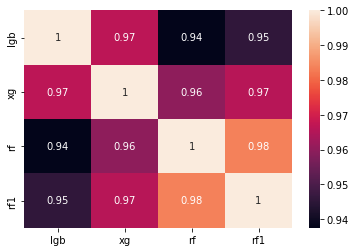

In [124]:
lgb_pred1 = pd.Series(np.ravel(10 ** lgb_pred - 1), name="lgb")
rf_pred1 = pd.Series(np.ravel(10 ** rf_pred - 1), name="rf")
rf_pred2 = pd.Series(np.ravel(10 ** rf1_pred - 1), name="rf1")
# cb_pred1 = pd.Series(np.ravel(10 ** scaler.inverse_transform([[elmt] for elmt in cb_pred]) - 1), name="cb")
xg_pred1 = pd.Series(np.ravel(10 ** xg_pred - 1), name="xg")
# lr_pred1 = pd.Series(np.ravel(10 ** scaler.inverse_transform([[elmt] for elmt in lr_pred]) - 1), name="lr")
# svr_pred1 = pd.Series(np.ravel(10 ** scaler.inverse_transform([[elmt] for elmt in svr_pred]) - 1), name="svr")
# sgd_pred1 = pd.Series(np.ravel(10 ** scaler.inverse_transform([[elmt] for elmt in sgd_pred]) - 1), name="sgd")

# Concatenate all classifier results
ensemble_results = pd.concat([lgb_pred1, xg_pred1, rf_pred1, rf_pred2],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

In [141]:
avg_prediction = np.mean([
    lgb_pred,
    rf_pred,
    #cb_pred,
    xg_pred,
], axis=0)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

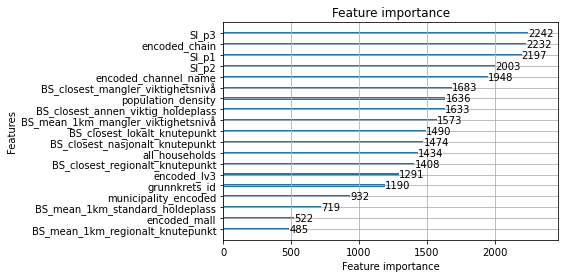

In [108]:
lgb.plot_importance(lgb_model)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

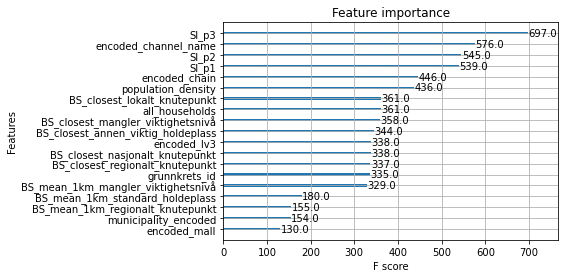

In [109]:
plot_importance(xg_model)

In [144]:
# Generate submission dataframe 
# NOTE: It is important that the ID and predicted values match
submission = pd.DataFrame()
submission['id'] = df_test.store_id 
#submission['predicted'] = np.asarray(10 ** scaler.inverse_transform([[elmt] for elmt in avg_prediction]) - 1)
submission['predicted'] = np.asarray(10 ** avg_prediction - 1)
#submission['predicted'] = np.asarray(lgb_pred)

# Save it to disk (`index=False` means don't save the index in the csv)
submission.to_csv('submission_full.csv', index=False)
submission

,id,predicted
0,914206820-914239427-717245,1.710217
1,916789157-916823770-824309,3.154913
2,913341082-977479363-2948,5.643870
3,889682582-889697172-28720,8.405816
4,997991699-998006945-417222,4.753275
...,...,...
8572,917323003-917383529-844309,2.302539
8573,917353379-917411824-845904,1.280941
8574,917072302-917089248-833647,3.732070
8575,916960557-916993161-829908,1.573791


In [145]:
submission.min()

id           810130822-971657243-219275
predicted                      0.065935
dtype: object